# Help Twitter Combat Hate Speech Using NLP and Machine Learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. Load the tweets file using read_csv function from Pandas package

In [2]:
df = pd.read_csv('TwitterHate.csv')

In [3]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


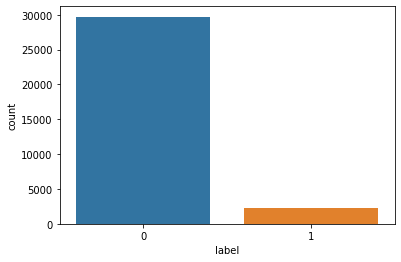

In [6]:
sns.countplot(df['label'])

In [7]:
df[df['label'] == 1].values[:10]

array([[14, 1,
        "@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  "],
       [15, 1,
        'no comment!  in #australia   #opkillingbay #seashepherd #helpcovedolphins #thecove  #helpcovedolphins'],
       [18, 1, 'retweet if you agree! '],
       [24, 1, '@user @user lumpy says i am a . prove it lumpy.'],
       [35, 1,
        "it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia "],
       [57, 1, '@user lets fight against  #love #peace '],
       [69, 1,
        "ð\x9f\x98©the white establishment can't have blk folx running around loving themselves and promoting our greatness  "],
       [78, 1,
        "@user hey, white people: you can call people 'white' by @user  #race  #identity #medâ\x80¦"],
       [83, 1,
        'how the #altright uses  &amp; insecurity to lure men into #whitesupremacy    '],
       [112, 1,
        "@user i'm not interested in a #linguistics that doesn't address #race &amp; .

In [8]:
df['label'].value_counts(normalize=True)

0    0.929854
1    0.070146
Name: label, dtype: float64

0 is positive tweet and 1 is negative tweet. There is a class imbalance problem here. 93 % of the tweets are non hate and 7% is hate.

## 2. Get the tweets into a list for easy text cleanup and manipulation.

In [9]:

tweets = df['tweet'].values
tweets[:5]

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
       "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
       '  bihday your majesty',
       '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
       ' factsguide: society now    #motivation'], dtype=object)

## 3.To cleanup: 

### 1.Normalize the casing.

In [10]:
tweets = [tweet.lower() for tweet in tweets]
tweets[:5]

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide: society now    #motivation']

### 2. Using regular expressions, remove user handles. These begin with '@’.

In [11]:
pattern = re.compile(re.escape('@'))

In [12]:
tweets = [pattern.sub('',tweet) for tweet in tweets]

In [13]:
tweets[:10]

[' user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "user user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide: society now    #motivation',
 '[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  ',
 ' user camping tomorrow user user user user user user user dannyâ\x80¦',
 "the next school year is the year for exams.ð\x9f\x98¯ can't think about that ð\x9f\x98\xad #school #exams   #hate #imagine #actorslife #revolutionschool #girl",
 'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ ',
 " user user welcome here !  i'm   it's so #gr8 ! "]

### 3.Using regular expressions, remove URLs.

In [14]:
pattern = re.compile(r'((ftp|http|https):\/\/)?www\.([A-z]+)\.([A-z]{2,})')

In [15]:
#pattern = re.compile('user')

In [16]:
pattern

re.compile(r'((ftp|http|https):\/\/)?www\.([A-z]+)\.([A-z]{2,})', re.UNICODE)

In [17]:
#tweets = [pattern.sub('',tweet) for tweet in tweets]

In [18]:
matches = []
for tweet in tweets:
  matches.append(pattern.finditer(tweet))

In [19]:
for match in matches:
   for m in match:
    print(m)

<re.Match object; span=(41, 55), match='www.flybcc.com'>
<re.Match object; span=(44, 69), match='www.smokeweedeatbacon.com'>


In [20]:
tweets = [pattern.sub('',tweet) for tweet in tweets]

In [21]:
matches = []
for tweet in tweets:
  matches.append(pattern.finditer(tweet))

In [22]:
for match in matches:
   for m in match:
    print(m)

### 4. Using TweetTokenizer from NLTK, tokenize the tweets into individual terms.

In [23]:
tokenizer = TweetTokenizer()
tokens = []
for tweet in tweets:
    tokens.append(tokenizer.tokenize(tweet))


In [24]:
tokens[0]

['user',
 'when',
 'a',
 'father',
 'is',
 'dysfunctional',
 'and',
 'is',
 'so',
 'selfish',
 'he',
 'drags',
 'his',
 'kids',
 'into',
 'his',
 'dysfunction',
 '.',
 '#run']

### 5. Remove stop words.

In [25]:
# filter out stop words
stop_words = set(stopwords.words('english'))
stopword_removed = []
for sent in tokens:    
    stopword_removed.append([word for word in sent if not word in stop_words])

In [26]:
stopword_removed[0]

['user',
 'father',
 'dysfunctional',
 'selfish',
 'drags',
 'kids',
 'dysfunction',
 '.',
 '#run']

### 6.  Remove redundant terms like ‘amp’, ‘rt’, etc.

In [27]:
pattern = re.compile(r'&')


In [28]:
matches = []
for sent in stopword_removed:
    for word in sent:
        matches.append(pattern.finditer(word))

In [29]:
for match in matches:
    for m in match:
        print(m)


<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), mat

In [30]:
amp_removed = []
for sent in stopword_removed:
    amp_removed.append([pattern.sub("",word) for word in sent])

In [31]:
amp_removed

[['user',
  'father',
  'dysfunctional',
  'selfish',
  'drags',
  'kids',
  'dysfunction',
  '.',
  '#run'],
 ['user',
  'user',
  'thanks',
  '#lyft',
  'credit',
  "can't",
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  '.',
  '#disapointed',
  '#getthanked'],
 ['bihday', 'majesty'],
 ['#model',
  'love',
  'u',
  'take',
  'u',
  'time',
  'urð',
  '\x9f',
  '\x93',
  '±',
  '!',
  '!',
  '!',
  'ð',
  '\x9f',
  '\x98',
  '\x99',
  'ð',
  '\x9f',
  '\x98',
  '\x8e',
  'ð',
  '\x9f',
  '\x91',
  '\x84',
  'ð',
  '\x9f',
  '\x91',
  'ð',
  '\x9f',
  '\x92',
  '¦',
  'ð',
  '\x9f',
  '\x92',
  '¦',
  'ð',
  '\x9f',
  '\x92',
  '¦'],
 ['factsguide', ':', 'society', '#motivation'],
 ['[',
  '2/2',
  ']',
  'huge',
  'fan',
  'fare',
  'big',
  'talking',
  'leave',
  '.',
  'chaos',
  'pay',
  'disputes',
  'get',
  '.',
  '#allshowandnogo'],
 ['user',
  'camping',
  'tomorrow',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'dannyâ',
  '\x8

In [32]:
# Re-check if the '&" is removed.
matches = []
for sent in amp_removed:
    for word in sent:
        matches.append(pattern.finditer(word))

In [33]:
for match in matches:
    for m in match:
        print(m)


The match returns no results, which means '&' is removed.

### 7. Remove ‘#’ symbols from the tweet while retaining the term.

In [34]:
amp_removed

[['user',
  'father',
  'dysfunctional',
  'selfish',
  'drags',
  'kids',
  'dysfunction',
  '.',
  '#run'],
 ['user',
  'user',
  'thanks',
  '#lyft',
  'credit',
  "can't",
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  '.',
  '#disapointed',
  '#getthanked'],
 ['bihday', 'majesty'],
 ['#model',
  'love',
  'u',
  'take',
  'u',
  'time',
  'urð',
  '\x9f',
  '\x93',
  '±',
  '!',
  '!',
  '!',
  'ð',
  '\x9f',
  '\x98',
  '\x99',
  'ð',
  '\x9f',
  '\x98',
  '\x8e',
  'ð',
  '\x9f',
  '\x91',
  '\x84',
  'ð',
  '\x9f',
  '\x91',
  'ð',
  '\x9f',
  '\x92',
  '¦',
  'ð',
  '\x9f',
  '\x92',
  '¦',
  'ð',
  '\x9f',
  '\x92',
  '¦'],
 ['factsguide', ':', 'society', '#motivation'],
 ['[',
  '2/2',
  ']',
  'huge',
  'fan',
  'fare',
  'big',
  'talking',
  'leave',
  '.',
  'chaos',
  'pay',
  'disputes',
  'get',
  '.',
  '#allshowandnogo'],
 ['user',
  'camping',
  'tomorrow',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'dannyâ',
  '\x8

In [35]:
pattern = re.compile('#')

In [36]:
matches = []
for sent in amp_removed:
    for word in sent:
        matches.append(pattern.finditer(word))
    

In [37]:
for match in matches:
    for m in match:
        print(m)

Streaming output truncated to the last 5000 lines.
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0

In [38]:
hashtag_removed = []
for sent in amp_removed:
    hashtag_removed.append([pattern.sub("",word) for word in sent])

In [39]:
hashtag_removed

[['user',
  'father',
  'dysfunctional',
  'selfish',
  'drags',
  'kids',
  'dysfunction',
  '.',
  'run'],
 ['user',
  'user',
  'thanks',
  'lyft',
  'credit',
  "can't",
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  '.',
  'disapointed',
  'getthanked'],
 ['bihday', 'majesty'],
 ['model',
  'love',
  'u',
  'take',
  'u',
  'time',
  'urð',
  '\x9f',
  '\x93',
  '±',
  '!',
  '!',
  '!',
  'ð',
  '\x9f',
  '\x98',
  '\x99',
  'ð',
  '\x9f',
  '\x98',
  '\x8e',
  'ð',
  '\x9f',
  '\x91',
  '\x84',
  'ð',
  '\x9f',
  '\x91',
  'ð',
  '\x9f',
  '\x92',
  '¦',
  'ð',
  '\x9f',
  '\x92',
  '¦',
  'ð',
  '\x9f',
  '\x92',
  '¦'],
 ['factsguide', ':', 'society', 'motivation'],
 ['[',
  '2/2',
  ']',
  'huge',
  'fan',
  'fare',
  'big',
  'talking',
  'leave',
  '.',
  'chaos',
  'pay',
  'disputes',
  'get',
  '.',
  'allshowandnogo'],
 ['user',
  'camping',
  'tomorrow',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'dannyâ',
  '\x80',
  '

In [40]:
# Re-check if '#' is removed.
matches = []
for sent in hashtag_removed:
    for word in sent:
        matches.append(pattern.finditer(word))

In [41]:
for match in matches:
    for m in match:
        print(m)

The match returns no results, which means '#' is removed.

## 4. Extra cleanup by removing terms with a length of 1.

In [42]:
smallword_removed = []
for sent in hashtag_removed:
    smallword_removed.append([word for word in sent if len(word) > 1])

In [43]:
smallword_removed

[['user',
  'father',
  'dysfunctional',
  'selfish',
  'drags',
  'kids',
  'dysfunction',
  'run'],
 ['user',
  'user',
  'thanks',
  'lyft',
  'credit',
  "can't",
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  'disapointed',
  'getthanked'],
 ['bihday', 'majesty'],
 ['model', 'love', 'take', 'time', 'urð'],
 ['factsguide', 'society', 'motivation'],
 ['2/2',
  'huge',
  'fan',
  'fare',
  'big',
  'talking',
  'leave',
  'chaos',
  'pay',
  'disputes',
  'get',
  'allshowandnogo'],
 ['user',
  'camping',
  'tomorrow',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'dannyâ'],
 ['next',
  'school',
  'year',
  'year',
  'exams',
  "can't",
  'think',
  'school',
  'exams',
  'hate',
  'imagine',
  'actorslife',
  'revolutionschool',
  'girl'],
 ['love',
  'land',
  'allin',
  'cavs',
  'champions',
  'cleveland',
  'clevelandcavaliers'],
 ['user', 'user', 'welcome', "i'm", 'gr8'],
 ['ireland',
  'consumer',
  'price',
  'index',
  'mom',
 

In [44]:
# Also remove any words that are not alpha
only_alpha = []
for sent in smallword_removed:
    only_alpha.append([word for word in sent if word.isalpha()])

In [45]:
only_alpha[:5]

[['user',
  'father',
  'dysfunctional',
  'selfish',
  'drags',
  'kids',
  'dysfunction',
  'run'],
 ['user',
  'user',
  'thanks',
  'lyft',
  'credit',
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  'disapointed',
  'getthanked'],
 ['bihday', 'majesty'],
 ['model', 'love', 'take', 'time', 'urð'],
 ['factsguide', 'society', 'motivation'],
 ['huge',
  'fan',
  'fare',
  'big',
  'talking',
  'leave',
  'chaos',
  'pay',
  'disputes',
  'get',
  'allshowandnogo'],
 ['user',
  'camping',
  'tomorrow',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'dannyâ'],
 ['next',
  'school',
  'year',
  'year',
  'exams',
  'think',
  'school',
  'exams',
  'hate',
  'imagine',
  'actorslife',
  'revolutionschool',
  'girl'],
 ['love',
  'land',
  'allin',
  'cavs',
  'champions',
  'cleveland',
  'clevelandcavaliers'],
 ['user', 'user', 'welcome'],
 ['ireland',
  'consumer',
  'price',
  'index',
  'mom',
  'climbed',
  'previous',
  'may',
  'blog',


## 5.Check out the top terms in the tweets:

### 1. First, get all the tokenized terms into one large list.

In [46]:
only_alpha

[['user',
  'father',
  'dysfunctional',
  'selfish',
  'drags',
  'kids',
  'dysfunction',
  'run'],
 ['user',
  'user',
  'thanks',
  'lyft',
  'credit',
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  'disapointed',
  'getthanked'],
 ['bihday', 'majesty'],
 ['model', 'love', 'take', 'time', 'urð'],
 ['factsguide', 'society', 'motivation'],
 ['huge',
  'fan',
  'fare',
  'big',
  'talking',
  'leave',
  'chaos',
  'pay',
  'disputes',
  'get',
  'allshowandnogo'],
 ['user',
  'camping',
  'tomorrow',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'dannyâ'],
 ['next',
  'school',
  'year',
  'year',
  'exams',
  'think',
  'school',
  'exams',
  'hate',
  'imagine',
  'actorslife',
  'revolutionschool',
  'girl'],
 ['love',
  'land',
  'allin',
  'cavs',
  'champions',
  'cleveland',
  'clevelandcavaliers'],
 ['user', 'user', 'welcome'],
 ['ireland',
  'consumer',
  'price',
  'index',
  'mom',
  'climbed',
  'previous',
  'may',
  'blog',


In [47]:
allwords = []
for sent in only_alpha:
    for word in sent:
        allwords.append(word)

In [48]:
allwords

['user',
 'father',
 'dysfunctional',
 'selfish',
 'drags',
 'kids',
 'dysfunction',
 'run',
 'user',
 'user',
 'thanks',
 'lyft',
 'credit',
 'use',
 'cause',
 'offer',
 'wheelchair',
 'vans',
 'pdx',
 'disapointed',
 'getthanked',
 'bihday',
 'majesty',
 'model',
 'love',
 'take',
 'time',
 'urð',
 'factsguide',
 'society',
 'motivation',
 'huge',
 'fan',
 'fare',
 'big',
 'talking',
 'leave',
 'chaos',
 'pay',
 'disputes',
 'get',
 'allshowandnogo',
 'user',
 'camping',
 'tomorrow',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'dannyâ',
 'next',
 'school',
 'year',
 'year',
 'exams',
 'think',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl',
 'love',
 'land',
 'allin',
 'cavs',
 'champions',
 'cleveland',
 'clevelandcavaliers',
 'user',
 'user',
 'welcome',
 'ireland',
 'consumer',
 'price',
 'index',
 'mom',
 'climbed',
 'previous',
 'may',
 'blog',
 'silver',
 'gold',
 'forex',
 'selfish',
 'orlando',
 'standwithorlando',
 '

### 2.Use the counter and find the 10 most common terms.

In [49]:
top = Counter(allwords)
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,user,17534
1,love,2748
2,day,2274
3,happy,1684
4,time,1131
5,life,1118
6,like,1047
7,today,1013
8,new,994
9,thankful,946


# 6. Data formatting for predictive modeling:

### 1. Join the tokens back to form strings. This will be required for the vectorizers.

In [50]:
only_alpha[:5]

[['user',
  'father',
  'dysfunctional',
  'selfish',
  'drags',
  'kids',
  'dysfunction',
  'run'],
 ['user',
  'user',
  'thanks',
  'lyft',
  'credit',
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  'disapointed',
  'getthanked'],
 ['bihday', 'majesty'],
 ['model', 'love', 'take', 'time', 'urð'],
 ['factsguide', 'society', 'motivation'],
 ['huge',
  'fan',
  'fare',
  'big',
  'talking',
  'leave',
  'chaos',
  'pay',
  'disputes',
  'get',
  'allshowandnogo'],
 ['user',
  'camping',
  'tomorrow',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'user',
  'dannyâ'],
 ['next',
  'school',
  'year',
  'year',
  'exams',
  'think',
  'school',
  'exams',
  'hate',
  'imagine',
  'actorslife',
  'revolutionschool',
  'girl'],
 ['love',
  'land',
  'allin',
  'cavs',
  'champions',
  'cleveland',
  'clevelandcavaliers'],
 ['user', 'user', 'welcome'],
 ['ireland',
  'consumer',
  'price',
  'index',
  'mom',
  'climbed',
  'previous',
  'may',
  'blog',


In [51]:
df['tweet'] = only_alpha

In [52]:
df

,id,label,tweet
0,1,0,"[user, father, dysfunctional, selfish, drags, ..."
1,2,0,"[user, user, thanks, lyft, credit, use, cause,..."
2,3,0,"[bihday, majesty]"
3,4,0,"[model, love, take, time, urð]"
4,5,0,"[factsguide, society, motivation]"
...,...,...,...
31957,31958,0,"[ate, user, isz, youuu]"
31958,31959,0,"[see, nina, turner, airwaves, trying, wrap, ma..."
31959,31960,0,"[listening, sad, songs, monday, morning, otw, ..."
31960,31961,1,"[user, sikh, temple, vandalised, calgary, wso,..."


### 2. Assign x and y.

In [53]:
X = df['tweet']
y = df['label']

In [54]:
print(X)
print(y)

0        [user, father, dysfunctional, selfish, drags, ...
1        [user, user, thanks, lyft, credit, use, cause,...
2                                        [bihday, majesty]
3                           [model, love, take, time, urð]
4                        [factsguide, society, motivation]
                               ...                        
31957                              [ate, user, isz, youuu]
31958    [see, nina, turner, airwaves, trying, wrap, ma...
31959    [listening, sad, songs, monday, morning, otw, ...
31960    [user, sikh, temple, vandalised, calgary, wso,...
31961                                [thank, user, follow]
Name: tweet, Length: 31962, dtype: object
0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64


### 3. Perform train_test_split using sklearn.

 

In [55]:
# Split the data into training and testing data - 90% train and 10% test

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.1, random_state = 100)

In [56]:
print(X_train[:5])
print(X_test[:5])
print(y_train[:5])
print(y_test[:5])

5968     [eid, sms, poetry, sms, jaun, elia, funey, sms...
1718     [zumba, day, keeps, us, allday, alltheway, tha...
15202    [user, fun, tease, blog, fun, laugh, enteainme...
11315    [fridayfeeling, winery, today, full, bmw, conv...
13669                      [user, god, speed, gordie, rip]
Name: tweet, dtype: object
21916    [make, morning, coffee, sunny, pineapples, sun...
18932    [ireland, rooster, simulation, want, climb, va...
26746             [confident, strong, boom, snap, fitness]
250      [user, happy, conference, right, mindset, lead...
3735      [snapchat, ripchristina, snap, snapchat, crying]
Name: tweet, dtype: object
5968     0
1718     0
15202    0
11315    0
13669    0
Name: label, dtype: int64
21916    0
18932    0
26746    0
250      0
3735     0
Name: label, dtype: int64


In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28765,)
(3197,)
(28765,)
(3197,)


In [58]:
y_train.value_counts(normalize=True)

0    0.928941
1    0.071059
Name: label, dtype: float64

In [59]:
y_test.value_counts(normalize=True)

0    0.938067
1    0.061933
Name: label, dtype: float64

## 7. We’ll use TF-IDF values for the terms as a feature to get into a vector space model.

### 1. Import TF-IDF  vectorizer from sklearn

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [61]:
X_train

5968     [eid, sms, poetry, sms, jaun, elia, funey, sms...
1718     [zumba, day, keeps, us, allday, alltheway, tha...
15202    [user, fun, tease, blog, fun, laugh, enteainme...
11315    [fridayfeeling, winery, today, full, bmw, conv...
13669                      [user, god, speed, gordie, rip]
                               ...                        
12119    [chosen, happy, life, you, me, question, healt...
24423                       [model, love, take, time, urð]
14147                                                [sad]
23320    [happy, bihday, inshot, girls, cute, summer, b...
5640     [happiness, warm, puppy, especially, waiting, ...
Name: tweet, Length: 28765, dtype: object

In [62]:
X_train = X_train.map(' '.join)


In [63]:
X_test = X_test.map(' '.join)

### 2. Instantiate with a maximum of 5000 terms in your vocabulary. 

In [64]:
X_train

5968     eid sms poetry sms jaun elia funey sms ur mobi...
1718         zumba day keeps us allday alltheway thankyouâ
15202    user fun tease blog fun laugh enteainment funn...
11315    fridayfeeling winery today full bmw conveible ...
13669                            user god speed gordie rip
                               ...                        
12119    chosen happy life you me question health futur...
24423                             model love take time urð
14147                                                  sad
23320    happy bihday inshot girls cute summer blur sun...
5640     happiness warm puppy especially waiting us hom...
Name: tweet, Length: 28765, dtype: object

In [65]:
X_test

21916    make morning coffee sunny pineapples sunshine ...
18932    ireland rooster simulation want climb vast exp...
26746                   confident strong boom snap fitness
250      user happy conference right mindset leads orga...
3735            snapchat ripchristina snap snapchat crying
                               ...                        
15701    user could simply delete flagged vids reinstat...
23757                           impoant things allow child
1829     friday gdegblog friday selfie beard gayguy gay...
18151    user user see spew user called shows like user...
7464         user engagement white calls nig user subhuman
Name: tweet, Length: 3197, dtype: object

### 3.Fit and apply on the train set.

In [66]:
vectorizer = TfidfVectorizer(max_features=5000)

# tokenize and build vocab
vectorizer.fit(X_train)
# encode document
training_features = vectorizer.transform(X_train)

### 4. Apply on test set 

In [67]:
test_features = vectorizer.transform(X_test)

In [68]:
training_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
test_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 8. Model building: Ordinary Logistic Regression

### 1. Instantiate Logistic Regression from sklearn with default parameters.

In [70]:
logReg = LogisticRegression()

### 2. Fit into  the train data. 

In [71]:
logReg.fit(training_features,y_train)

LogisticRegression()

### 3. Make predictions for the train and the test set. 

In [72]:
# predict the y based on X_test.
prediction = logReg.predict(test_features)

In [73]:
prediction

array([0, 0, 0, ..., 0, 0, 1])

## 9. Model evaluation: Accuracy, recall, and f_1 score. 

### 1. Report the accuracy on the test set. 

In [74]:
# Accuracy score for the model
from sklearn import metrics
print(metrics.accuracy_score(y_test,prediction))

0.9537065999374413


In [75]:
# Confusion matrix for the model
cm = metrics.confusion_matrix(y_test, prediction)

In [76]:
cm

array([[2992,    7],
       [ 141,   57]])

### 2. Report the recall and f1 score 

In [77]:
print("\n" + classification_report(y_test,prediction))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2999
           1       0.89      0.29      0.44       198

    accuracy                           0.95      3197
   macro avg       0.92      0.64      0.71      3197
weighted avg       0.95      0.95      0.94      3197



The F1 score is 0.98 for class 0 (majority) and 0.44 for class 1 (minority).

## 10. Looks like you need to adjust the class imbalance, as the model seems to focus on the 0s.

### 1. Adjust the appropriate class in the LogisticRegression model.

Our majority class(0) value count is 0.929854 and minority class(1) value count is 0.070146. 
to correct the class imbalance, We set a higher weight for minority class and reduce the weight for the majority class.
Here we can set weights such that minority class is 13 times more than majority class.


## 11. Train again with the adjustment and evaluate.

In [78]:
logReg = LogisticRegression(class_weight={0:0.070146 , 1: 0.929854})
logReg.fit(training_features,y_train)
# predict the y based on X_test.
prediction = logReg.predict(test_features)

In [79]:
# Confusion matrix for the model
cm = metrics.confusion_matrix(y_test, prediction)
cm

array([[2735,  264],
       [  44,  154]])

In [80]:
print("\n" + classification_report(y_test,prediction))


              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2999
           1       0.37      0.78      0.50       198

    accuracy                           0.90      3197
   macro avg       0.68      0.84      0.72      3197
weighted avg       0.95      0.90      0.92      3197



The F1 score is 0.95 for class 0 (majority) and 0.50 for class 1 (minority).

## 12. Use a balanced class weight while instantiating the logistic regression.

In [81]:
logReg = LogisticRegression(class_weight='balanced')
logReg.fit(training_features,y_train)
# predict the y based on X_test.
prediction = logReg.predict(test_features)

In [82]:
# Confusion matrix for the model
cm = metrics.confusion_matrix(y_test, prediction)
cm

array([[2787,  212],
       [  48,  150]])

In [83]:
print("\n" + classification_report(y_test,prediction))


              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2999
           1       0.41      0.76      0.54       198

    accuracy                           0.92      3197
   macro avg       0.70      0.84      0.75      3197
weighted avg       0.95      0.92      0.93      3197



The F1 score is 0.96 for class 0 (majority) and 0.54 for class 1 (minority).

## 13. Regularization and Hyperparameter tuning: 

### 1. Import GridSearch and StratifiedKFold because of class imbalance. 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

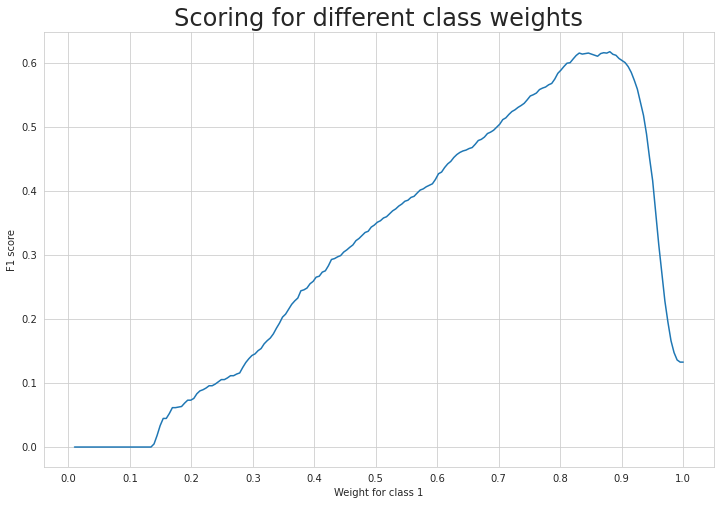

In [84]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(training_features, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [85]:
weigh_data.sort_values(by="score",ascending=False)

,score,weight
24,0.617755,0.880603
26,0.616144,0.870653
31,0.615627,0.845779
34,0.615620,0.830854
25,0.615542,0.875628
...,...,...
177,0.000000,0.119447
176,0.000000,0.124422
175,0.000000,0.129397
174,0.000000,0.134372


using gridsearch and stratified kfold cv, we found the optimal weights which give the highest f1 score. 
Weight for class 1(minority class) is 0.880603. Weight for class 0(majority class) is 1-0.880603 which is 0.119397.
Lets apply these weights and run the code once more.

In [86]:
logReg = LogisticRegression(class_weight={0:0.119397,1:0.880603})
logReg.fit(training_features,y_train)
# predict the y based on X_test.
prediction = logReg.predict(test_features)

In [87]:
# Confusion matrix for the model
cm = metrics.confusion_matrix(y_test, prediction)
cm

array([[2908,   91],
       [  70,  128]])

In [88]:
print("\n" + classification_report(y_test,prediction))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2999
           1       0.58      0.65      0.61       198

    accuracy                           0.95      3197
   macro avg       0.78      0.81      0.79      3197
weighted avg       0.95      0.95      0.95      3197



The F1 score is 0.97 for class 0 (majority) and 0.61 for class 1 (minority). We tried to create a balance by getting decent f1 scores of both class 0 and class 1 using the gridsearch and stratified k-fold.

In [89]:
X_test

21916    make morning coffee sunny pineapples sunshine ...
18932    ireland rooster simulation want climb vast exp...
26746                   confident strong boom snap fitness
250      user happy conference right mindset leads orga...
3735            snapchat ripchristina snap snapchat crying
                               ...                        
15701    user could simply delete flagged vids reinstat...
23757                           impoant things allow child
1829     friday gdegblog friday selfie beard gayguy gay...
18151    user user see spew user called shows like user...
7464         user engagement white calls nig user subhuman
Name: tweet, Length: 3197, dtype: object

In [90]:
prediction.shape

(3197,)

In [92]:
df = pd.DataFrame(X_test)

In [93]:
df['prediction'] = prediction

In [94]:
df.sort_values(by="prediction",ascending=False)[:10]

,tweet,prediction
7464,user engagement white calls nig user subhuman,1
6634,patriotwatch projection auspol rwnj upf cult c...,1
1768,japan abe government mere puppet ultra rightis...,1
26488,user makes trump candidacy wohwhile donaldtrum...,1
21043,user allahsoil crusaderâ west vs islamic terro...,1
9602,user dear user user user user would please ask...,1
12232,user user user,1
11038,user user user user user user user single race,1
12704,statement doubling paladino media comments avo...,1
30545,sikh temple vandalised calgary wso condemns act,1


We can see that the model has indeed identified the racist and hate tweets correctly.

## Conclusion

In this project, we worked on classfying the twitter tweets as non-hate and hate tweets. 
We did text processing by removing &,#,stop words,non alpha etc and we converted the tweets to tokens.
Also, we did feature engineering by converting the words to vectors using tf-idf. 
Next we assigned X and y and split our data. We used logistic regression to train our model. We dealt with class imbalance by adjusting weights for the majority and minority classes. We tried using balanced weights to improve the f1 score. 
Lastly, we used gridsearch cv and stratified k-fold to find the optimal weights for the 0 and 1 classes.
We were able to build a decent model with a f1 score of 97 for majority class and 61 for minority class.